# Projet statistique descriptive 



In [1]:
%reload_ext autoreload
%autoreload 2

# module
import sys
sys.path.append("../")
from src import * 

# chemin vers la donnee 
data_dir = 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive/'
filelist = glob.glob(data_dir + '*.h5')
filelist

['C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_01.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_01_dask.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_02.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_02_dask.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_03.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_03_dask.h5']

In [2]:
from tabata import Opset

In [3]:
df_opset1=Opset('C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_01.h5')
df_opset2=Opset('C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_02.h5')
df_opset3=Opset('C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_03.h5')

In [4]:
df_opset1

OPSET 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\Aircraft_01.h5' de 1002 signaux.
        position courante : sigpos  = 0
        variable courante : colname = ALT [ft]
        phase surlignée   : phase   = None

In [5]:
df_opset1.plot()

In [6]:
type(df_opset2)

tabata.opset.Opset

In [7]:
df_opset2.plot()

In [ ]:
df_opset3.plot()

In [9]:
def eliminate_records(df):
    alt_min=df['ALT [ft]'].min()
    alt_max=df['ALT [ft]'].max()
    alt_range=alt_max-alt_min
    bol=False
    
    if alt_range<15000:
        bol=True
    return bol
    
    

In [10]:
#on cree notre dataframe avec DASK
ddf1 = lire_hdf_dask(filelist[0], repertoire= data_dir)
#on récupère une liste de booleen où chaque composante fait reférance à une partition 
I = ddf1.map_partitions(lambda df: eliminate_records(df)).compute()
#on sélectione dans un nouveau dataframe les partitions qui ne sont pas mauvaise
DDF1=ddf1.partitions[I==False]
# on normalise toute les données excepté les variables booleen 
ddf_norm1 = DDF1.map_partitions(lambda df : normalize(df))

ddf2 = lire_hdf_dask(filelist[2], repertoire= data_dir)
I = ddf2.map_partitions(lambda df: eliminate_records(df)).compute()
DDF2=ddf2.partitions[I==False]
ddf_norm2 = DDF2.map_partitions(lambda df : normalize(df))

ddf3 = lire_hdf_dask(filelist[3], repertoire= data_dir)
I = ddf3.map_partitions(lambda df: eliminate_records(df)).compute()
DDF3=ddf3.partitions[I==False]
ddf_norm3 = DDF3.map_partitions(lambda df : normalize(df))

C:\Users\felix\PycharmProjects\pythonProject1\projet_lacaille\stats_descriptive_project\notebooks\..\src\manipulate_dataframe.py:19: RuntimeWarning:

invalid value encountered in divide

C:\Users\felix\PycharmProjects\pythonProject1\projet_lacaille\stats_descriptive_project\notebooks\..\src\manipulate_dataframe.py:19: RuntimeWarning:

invalid value encountered in divide

C:\Users\felix\PycharmProjects\pythonProject1\projet_lacaille\stats_descriptive_project\notebooks\..\src\manipulate_dataframe.py:19: RuntimeWarning:

invalid value encountered in divide



In [12]:
df=ddf1.partitions[1].compute()
df['ALT [ft]'].min()

-134.462575892

# appliquer un filtrage sur l'egt pour recuperer les tendances
-> Quand est t'il du bruit ? ne risquons nous pas d'interpréter du bruit pour quelque chose de significatif


#calcul de la corelation entre l'usure et la vitesse d'altitude 
premièrement il faut repérer les valeur de vittesse de montée
Attention il faut fuiltrer les les valeurs pour éviter le parasitage 
on peut récupérer le temps passé a une altitude supérieur à un montant fixé 
et ainssi remarqueé une corélation entre ce temps fixée et une baisse de la marge EGT 
Attention l'egt est une valeur qu'on devra aussi filtrer 


In [84]:
def deriv_glissante(df):
    dy=np.zeros(len(df))
    y = df['ALT'].rolling(window = 20).mean()
    I = range(y.index[0], y.index[-1],20)
    dy[0:len(I)-1] = y[I[1:]].values- y[I[:-1]].values
    
    return [dy,I]

8035
8035


ValueError: x and y must have same first dimension, but have shapes (401,) and (8035,)

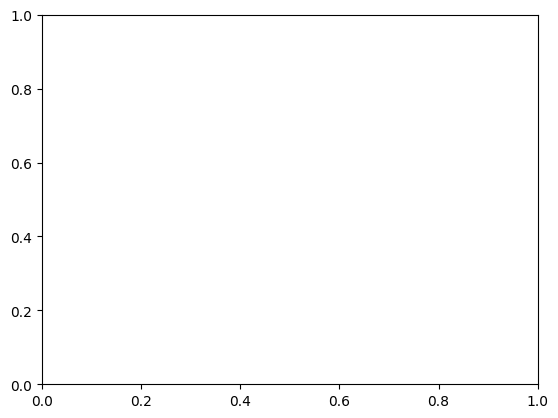

In [85]:
df12=ddf_norm1.partitions[59].compute()
dy2=np.zeros(len(df12))
[dy2,I2]=deriv_glissante(df12)
print(len(dy2))
print(len(df12))
plt.plot(I2[1:], dy2)

In [22]:
Derive = ddf1.map_partitions(lambda df: deriv_glissante(df)).compute()

In [41]:
df.assign(dy=lambda df: deriv_glissante(df))

ValueError: Length of values (372) does not match length of index (7459)

In [ ]:
#definie une fonction qui récupère les pahe de monté 
def monte(dy):
    #on récupère le premier indice quand la vitesse est différente de 0
    i=0
    while dy[i]<=8:
        i=++
    
    j=i
    #on récupère l'indice quand la vitesse deviens nulle 
    while dy[i]>8:
        j=j++
    
    #si la distance entre les deux indice i et j est trop petite on rejete 
    if j-i <400:
        print("Error valeur abérante")
    return(i,j)
    

In [ ]:
df[df['dy']>10] # ce qu'on veut théoriquement faire 

une fois avoir récuperer les indice de la monté on récupère la marge EGT sur cette monté 

# une manière alternative de calculer le temps paser en monter et de selectionner parmis les montés la vittesse en mac/S
Attention vérifié qu'i l n'y a pas de dépendance entre l'angle de l'avion et la vittesse mesuré ( je ne pense pas )

In [ ]:
# peut on prédire l'egt en fonction des température et des autre valeurs 

In [ ]:
#peut on analyser les données manquantes et peut être apporter un corectif  